# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<AxesSubplot:xlabel='week'>

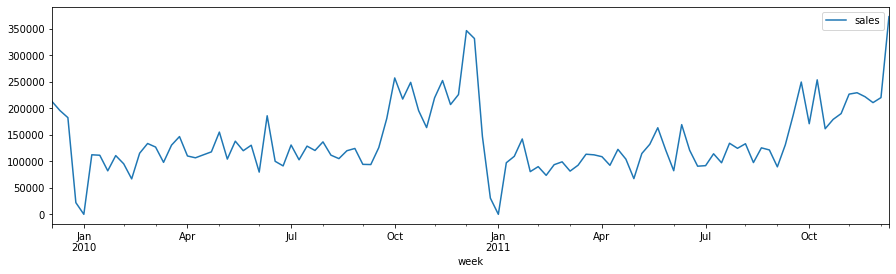

In [3]:
df.plot(figsize=[15, 4])

## Missing data

Check if there are missing values in the time series.

In [4]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

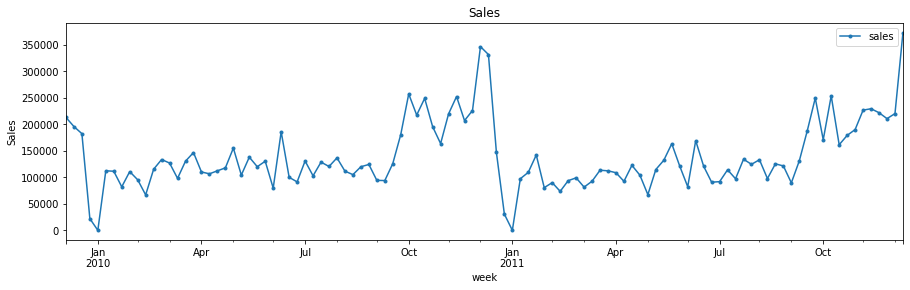

In [5]:
# Introduce the missing timestamps.
# Note that we capture this in a different dfframe.
df_ = df.asfreq("1W")

# Apply the forward fill method.
df_imputed = df_.fillna(method="ffill")

# plot the time series.
ax = df_.plot(linestyle="-", marker=".", figsize=[15, 4])

# plot the imputed values on top, in red.
df_imputed[df_.isnull()].plot(ax=ax, legend=None, marker=".", color="r")

# Add title.
plt.title("Sales")

# the y axis label
plt.ylabel("Sales")

plt.show()

## Seasonality

Does the time series show any obvious seasonal pattern?

Text(0, 0.5, 'Sales')

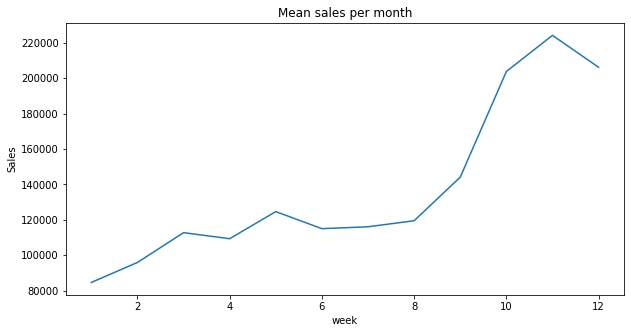

In [6]:
# Plot the average sales per month.

month = df.index.month

df.groupby(month)["sales"].mean().plot(figsize=(10, 5))
plt.title("Mean sales per month")
plt.ylabel("Sales")

Text(0, 0.5, 'Sales')

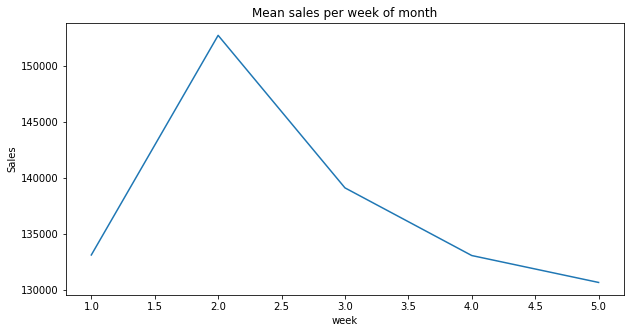

In [7]:
# Plot the average sales for every 1,2,3,4 and 5 week of a month.

wom = (df.index.day - 1) // 7 + 1

df.groupby(wom)["sales"].mean().plot(figsize=(10, 5))
plt.title("Mean sales per week of month")
plt.ylabel("Sales")

# Feature engineering

Now, let's begin to tabularize the data.

## Datetime features

In [8]:
# month of the year

df["month"] = df.index.month

df.head()

,sales,month
week,,
2009-12-06,213000.35,12
2009-12-13,195810.04,12
2009-12-20,182396.74,12
2009-12-27,22007.77,12
2010-01-03,0.00,1


In [9]:
# week of month

df['wom'] = (df.index.day -1) //7 + 1

## Cyclical features

In [10]:
cyclical = CyclicalFeatures(
    variables=["month", "wom"],  # The features to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

df.head()

,sales,month,wom,month_sin,month_cos,wom_sin,wom_cos
week,,,,,,,
2009-12-06,213000.35,12,1,-2.449294e-16,1.000000,0.951057,0.309017
2009-12-13,195810.04,12,2,-2.449294e-16,1.000000,0.587785,-0.809017
2009-12-20,182396.74,12,3,-2.449294e-16,1.000000,-0.587785,-0.809017
2009-12-27,22007.77,12,4,-2.449294e-16,1.000000,-0.951057,0.309017
2010-01-03,0.00,1,1,5.000000e-01,0.866025,0.951057,0.309017


## Lag features

In [11]:
# Sales the previous week.

tmp = pd.DataFrame(df["sales"].shift(freq="1W"))

# Name for the new variable.
tmp.columns = ["sales_lag_1"]

# Add the variable to the original df.
df = df.merge(tmp, left_index=True, right_index=True, how="left")

df.head()

,sales,month,wom,month_sin,month_cos,wom_sin,wom_cos,sales_lag_1
week,,,,,,,,
2009-12-06,213000.35,12,1,-2.449294e-16,1.000000,0.951057,0.309017,NaN
2009-12-13,195810.04,12,2,-2.449294e-16,1.000000,0.587785,-0.809017,213000.35
2009-12-20,182396.74,12,3,-2.449294e-16,1.000000,-0.587785,-0.809017,195810.04
2009-12-27,22007.77,12,4,-2.449294e-16,1.000000,-0.951057,0.309017,182396.74
2010-01-03,0.00,1,1,5.000000e-01,0.866025,0.951057,0.309017,22007.77


## Window features

In [12]:
# Here I take the average, maximum and minimum values
# of the previous 2 and 4 weeks.

for window in [2, 4]:
    
    tmp = df["sales"].rolling(window=window).agg(["mean", "max", "min"]).shift(1)

    tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]
    
    df = df.merge(tmp, left_index=True, right_index=True, how="left")

# view of the result
df.head(10)

,sales,month,wom,month_sin,month_cos,wom_sin,wom_cos,sales_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
week,,,,,,,,,,,,,,
2009-12-06,213000.350,12,1,-2.449294e-16,1.000000,9.510565e-01,0.309017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.040,12,2,-2.449294e-16,1.000000,5.877853e-01,-0.809017,213000.350,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.740,12,3,-2.449294e-16,1.000000,-5.877853e-01,-0.809017,195810.040,204405.1950,213000.350,195810.040,NaN,NaN,NaN
2009-12-27,22007.770,12,4,-2.449294e-16,1.000000,-9.510565e-01,0.309017,182396.740,189103.3900,195810.040,182396.740,NaN,NaN,NaN
2010-01-03,0.000,1,1,5.000000e-01,0.866025,9.510565e-01,0.309017,22007.770,102202.2550,182396.740,22007.770,153303.72500,213000.35,22007.770
2010-01-10,112318.850,1,2,5.000000e-01,0.866025,5.877853e-01,-0.809017,0.000,11003.8850,22007.770,0.000,100053.63750,195810.04,0.000
2010-01-17,111460.470,1,3,5.000000e-01,0.866025,-5.877853e-01,-0.809017,112318.850,56159.4250,112318.850,0.000,79180.84000,182396.74,0.000
2010-01-24,82065.331,1,4,5.000000e-01,0.866025,-9.510565e-01,0.309017,111460.470,111889.6600,112318.850,111460.470,61446.77250,112318.85,0.000
2010-01-31,110790.591,1,5,5.000000e-01,0.866025,-2.449294e-16,1.000000,82065.331,96762.9005,111460.470,82065.331,76461.16275,112318.85,0.000


## Drop missing data

In [13]:
# Find fraction of missing data.

df.isnull().sum() / len(df)

sales           0.000000
month           0.000000
wom             0.000000
month_sin       0.000000
month_cos       0.000000
wom_sin         0.000000
wom_cos         0.000000
sales_lag_1     0.009434
sales_2_mean    0.018868
sales_2_max     0.018868
sales_2_min     0.018868
sales_4_mean    0.037736
sales_4_max     0.037736
sales_4_min     0.037736
dtype: float64

In [14]:
df.dropna(inplace=True)

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [15]:
df.index.min(), df.index.max()

(Timestamp('2010-01-03 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [16]:
# Split the data in time.

X_train = df[df.index <= "2011-09-30"]
X_test = df[df.index > "2011-09-30"]

X_train.shape, X_test.shape

((91, 14), (11, 14))

In [17]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# the input features
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [18]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  45844.30745262792
test rmse:  65327.34284108387


## Machine Learning

### Random forests

In [19]:
rf_model = RandomForestRegressor(
    n_estimators=5,
    max_depth=1,
    random_state=0,
)

rf_model.fit(X_train, y_train)

# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  38630.62589645069
test rmse:  57764.311865163814


Text(0, 0.5, 'Importance')

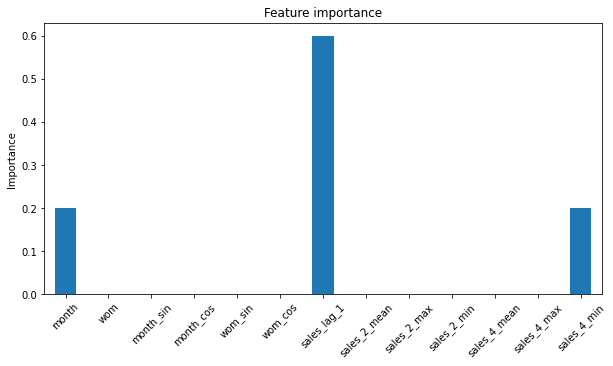

In [20]:
# Let's now plot the feature's importance
# according to the random forests.

# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

### Lasso

In [21]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  34836.61713978724
test rmse:  54602.94605229004


Text(0, 0.5, 'Importance')

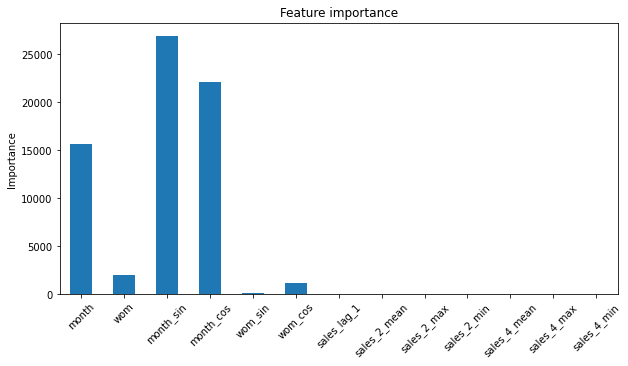

In [22]:
# Let's now plot the feature's importance
# according to the linear model.
from numpy import abs

# Create series with feature importance.
tmp = pd.Series(abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")